In [30]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
import mayavi.mlab
import laspy as lp
import cv2 as cv
from PIL import Image

In [2]:
# Load binary point cloud
bin_pcd = np.fromfile("/home/sourish-wicon-lab/Documents/WSN/data_road_velodyne/testing/velodyne/um_000001.bin", dtype=np.float32)

In [3]:
# Reshape and drop reflection values
points = bin_pcd.reshape((-1, 4))[:, 0:3]

# Convert to Open3D point cloud
o3d_pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(points))

# Save to whatever format you like
#o3d.io.write_point_cloud("pointcloud.pcd", o3d_pcd)

In [5]:
geom = o3d.geometry.PointCloud()
geom.points = o3d.utility.Vector3dVector(points)
o3d.visualization.draw_geometries([geom])

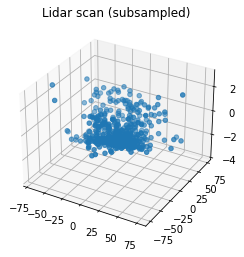

In [6]:
from mpl_toolkits.mplot3d import Axes3D
    
skip = 100 # plot one in every `skip` points

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
velo_range = range(0, points.shape[0], skip) # skip points to prevent crash
ax.scatter(points[velo_range, 0],   # x
                points[velo_range, 1],   # y
                points[velo_range, 2],   # z
                #c=points[velo_range, 3], # reflectance
                cmap='gray')
ax.set_title('Lidar scan (subsampled)')
plt.show()

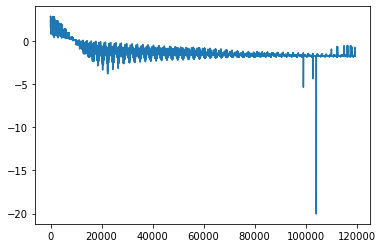

In [7]:
#Lidar Data
X = points[:,0]
Y = points[:,1]
Z = points[:,2]
plt.plot(Z)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.33333334 0.33333334 0.33333334 ... 0.14509805 0.12941177 0.11764706]
 [0.32156864 0.32156864 0.3254902  ... 0.14117648 0.1254902  0.11372549]
 [0.30588236 0.30980393 0.3137255  ... 0.13725491 0.12156863 0.10980392]]


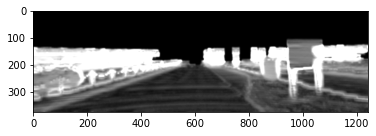

In [46]:
road_detect = plt.imread("/home/sourish-wicon-lab/Documents/WSN/ADI-testing/ADI/um_000000.png")
plt.imshow(road_detect,'gray')
#road_detect = np.array(road_detect,[1242,375])
#Routine to fix 
def fixColor(image):
    return(cv.cvtColor(image, cv.COLOR_BGR2RGB))
print(road_detect)

(1242, 375)


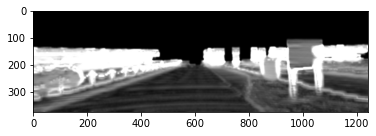

In [104]:
image = Image.open('/home/sourish-wicon-lab/Documents/WSN/ADI-testing/ADI/um_000000.png')
print(image.size)
image = np.array(image)
plt.imshow(fixColor(image))

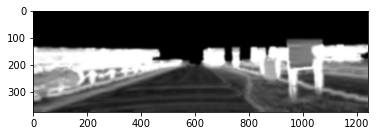

In [106]:

gray = cv.GaussianBlur(image
                       , (15,15), 0)
plt.imshow(fixColor(gray))

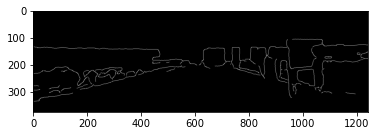

In [107]:
edges = cv.Canny(gray,2,100)
plt.imshow(edges,'gray')

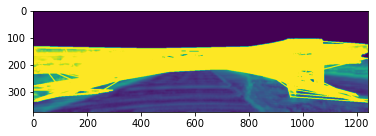

In [101]:
lines = cv.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold = 50, minLineLength=1000, maxLineGap=250)
for line in lines:
    x1, y1, x2, y2 = line[0]
    if (y1 > 100 or y2 > 100): #Filter out the lines in the top of the image
        cv.line(image, (x1, y1), (x2, y2), (255, 0, 0), 3)
plt.imshow(image)

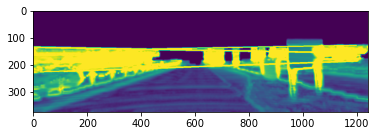